In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

## Optical flow

Bài toán optical flow yêu cầu xác định vector dịch chuyển của từng pixel trong ảnh từ frame $t$ sang frame $t+1$. Giả sử pixel $p=(x,y)$ có tọa độ bằng $(x(t), y(t))$ tại frame $t$ thì nhiệm vụ của bài toán là xác định vector dịch chuyển $(u, v) = p(t+1) - p(t)$ cho từng pixel $p$ dựa trên hai frame ảnh liên tiếp $I(t)$ và $I(t+1)$. 

Bài toán được giải quyết dựa trên hai giả thuyết sau:
1. Độ sáng của pixel tương ứng giữa hai frame ảnh không thay đổi. Cụ thể là $I(x(t), y(t), t) = C$
2. Độ lớn của vector dịch chuyển không quá lớn. Hay $(u,v) = (\frac{dx}{dt}, \frac{dy}{dt})$

Kết hợp hai giả thiết trên thì phương trình cần giải của bài toán bằng $$\frac{\partial I}{\partial x} \frac{dx}{dt} + \frac{\partial I}{\partial y} \frac{dy}{dt} + \frac{\partial I}{\partial t} = 0$$, trong đó
* $\frac{\partial I}{\partial x}, \frac{\partial I}{\partial y}$ - gradient của ảnh theo chiều $x$, $y$ có thể được xác định thông qua bộ lọc Sobel
* $\frac{\partial I}{\partial t}$ - sự thay đổi của giá trị pixel ảnh theo thời gian, xác định bằng $I(t+1) - I(t)$
* $\frac{dx}{dt} = u$, $\frac{dy}{dt} = v$ - hai ẩn cần tìm.

Khi đó, phương trình tương đương với một phương trình tuyến tính 2 ẩn. Nếu giả thiết thêm rằng các pixel lân cận (cửa sổ $3 \times 3$) cũng có vector dịch chuyển giống với pixel hiện tại đang xét thì khi đó ta thu được hệ 9 phương trình, 2 ẩn. Từ đó cho ra thuật toán Lucas-Kanade. Để có thể giải hệ phương trình một cách ổn đỉnh, pixel được theo dõi cần thỏa mãn tính chất góc Harris corner. 

Trong OpenCV, việc xác định tọa độ pixel các góc Harris trong ảnh xác định thông qua hàm `goodFeaturesToTrack`. Việc tracking Harris corner bằxxxng thuật toán lucas-kanade thực hiện bằng hàm `calcOpticalFlowPyrLK` với các tham số cần truyền
* `prevImg` - ảnh grayscale frame $t$ 
* `nextImg` - ảnh grayscale frame $t+1$
* `prevPts` - danh sách tọa độ các Harris corner tại frame $t$
* `winSize` - tham số của thuật toán lucas-kanade, cửa sổ lân cận các pixel cùng vector dịch chuyển
* `maxLevel` - tham số của thuật toán lucas-kanade
* `criteria` - tham số điều kiện dừng cho thuật toán lucas-kanade

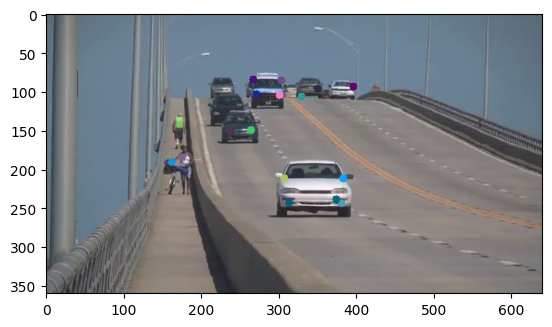

In [2]:
cap = cv.VideoCapture("../images/slow_traffic_small.mp4") # đọc video
ret, frame = cap.read() # đọc frame đầu tiên của video

# thông số truyền vào cho hàm goodFeaturesToTrack tìm các Harris corner
feature_params = dict(maxCorners = 100, 
                      qualityLevel = 0.3, 
                      k = 0.04, 
                      minDistance = 7) 

frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(frame_gray, **feature_params)

N_corners = len(corners)

colors = np.random.randint(0, 255, (N_corners, 3))

img = frame.copy()
for i, row in enumerate(corners):
    x, y = row.astype(np.int32).ravel()
    cv.circle(img, (x, y), 5, colors[i].tolist(), -1)

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

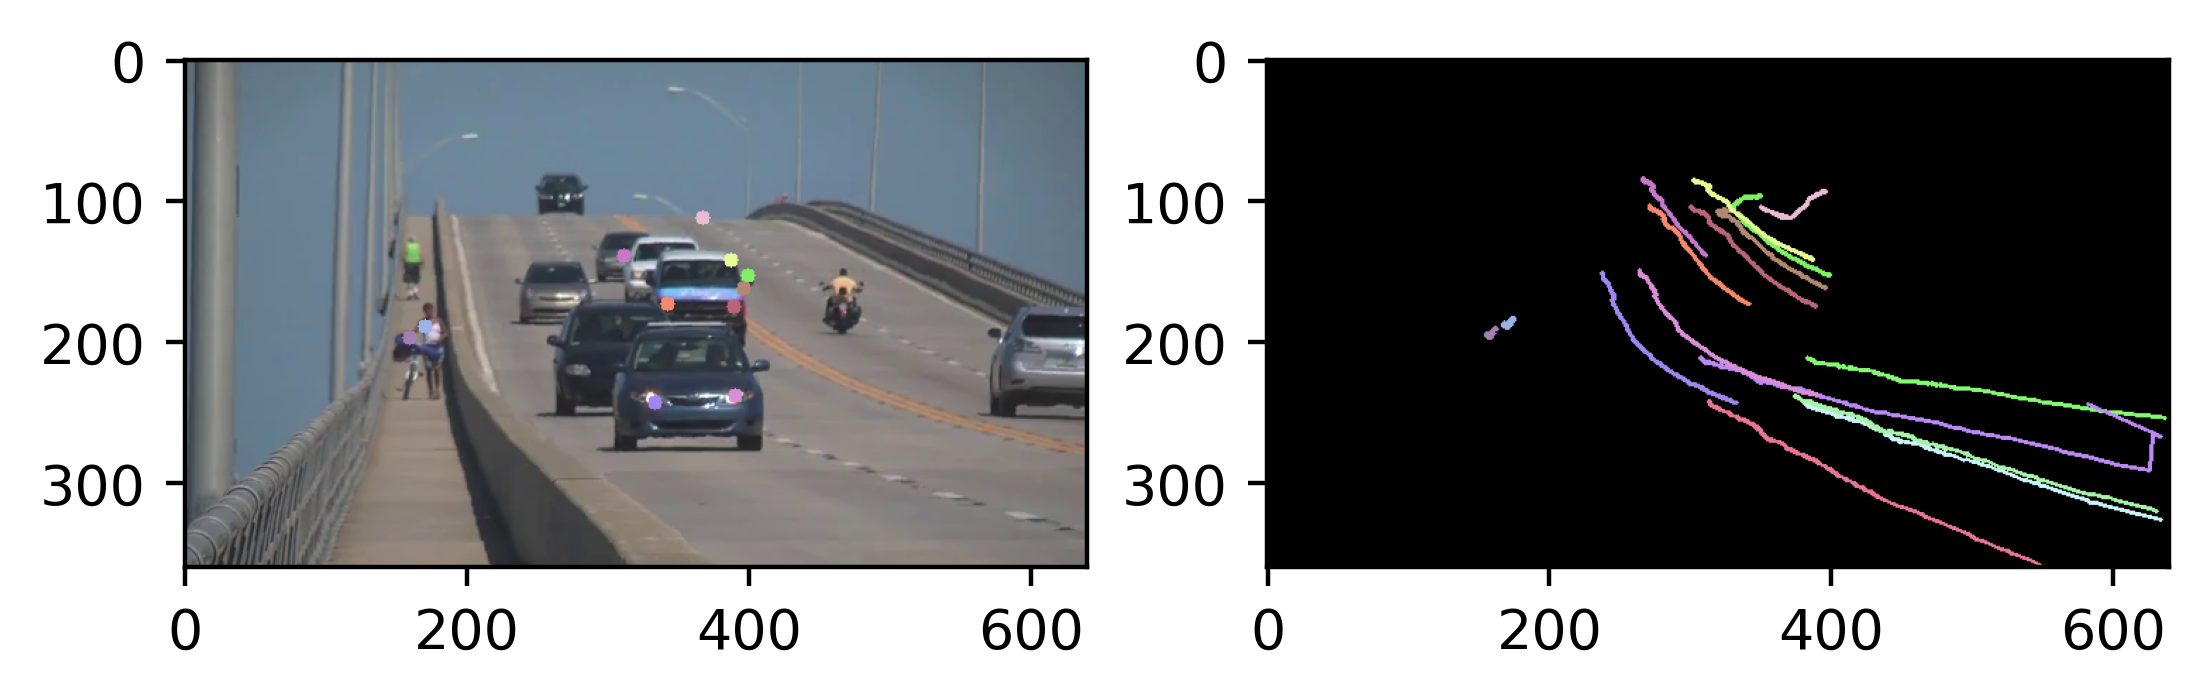

In [3]:
cap = cv.VideoCapture("../images/slow_traffic_small.mp4") # đọc video
ret, frame = cap.read() # đọc frame đầu tiên của video

# thông số truyền vào cho hàm goodFeaturesToTrack tìm các Harris corner
feature_params = dict(maxCorners = 100, 
                      qualityLevel = 0.3, 
                      k = 0.04, 
                      minDistance = 7) 

# thông số cho thuật toán lucas kanade
lk_params = dict(winSize = (5, 5),
                 maxLevel = 2,
                 criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(frame_gray, **feature_params)

N_corners = len(corners)

colors = np.random.randint(100, 255, (N_corners, 3))

prv_frame_gray = frame_gray.copy()

draw_tracks = np.zeros_like(frame) # vẽ tracking line các harris corner
count_frame = 0

plt.rcParams['figure.dpi'] = 400

while True:
    count_frame += 1

    ret, frame = cap.read() # đọc frame tiếp theo của video

    if not ret: break

    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    nxt_corners, status, error = cv.calcOpticalFlowPyrLK(prv_frame_gray, frame_gray, corners, None, **lk_params)
    status = status.reshape(-1)

    img = frame.copy()

    for i, (prv, cur) in enumerate(zip(corners, nxt_corners)):
        if status[i] == 0: continue 
        x_prv, y_prv = prv.astype(np.int32).ravel()
        x_cur, y_cur = cur.astype(np.int32).ravel()

        draw_tracks = cv.line(draw_tracks, (x_prv, y_prv), (x_cur, y_cur), colors[i].tolist(), 2)
        img = cv.circle(img, (x_cur, y_cur), 5, colors[i].tolist(), -1)
    
    # img[draw_tracks > 0] = draw_tracks[draw_tracks > 0]

    if count_frame % 5 == 0:
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.subplot(1, 2, 1)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.subplot(1, 2, 2)
        plt.imshow(cv.cvtColor(draw_tracks, cv.COLOR_BGR2RGB))
        plt.show()

    prv_frame_gray = frame_gray.copy()
    corners = nxt_corners[status==1]
    colors = colors[status==1]

    if count_frame == 250:
        break
